In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt


In [2]:
# --- 1. Load and Clean Data ---
# Load the generated synthetic data (assuming it's in the root folder)
df = pd.read_csv('../synthetic_batch_data.csv')

# Drop rows where CQAs are NaN (these are non-final time steps)
cqa_df = df.dropna(subset=['Final_Height']).copy()

# Identify Critical Process Parameters (CPPs) - the time-series variables
cpp_cols = ['Oven_Temp_Actual', 'Batter_Center_Temp', 'Stirrer_Power_Online']


In [5]:
# --- 2. Unfold Data (Transform 3D to 2D for Modeling) ---

# Pivot the data to get one row per batch, with time points as new columns (Batch x (Time*Variable))
# This is known as Batch-Wise Unfolding
unfolded_data = df.pivot(index='Batch_ID', columns='Time_Min', values=cpp_cols)

# Drop any batches that did not complete (if applicable, though synthetic data should be clean)
unfolded_data = unfolded_data.dropna()


In [7]:
# --- 3. Separate Golden Batches for Training ---
# Identify the Batch IDs corresponding to the 'Normal' (Golden) runs
golden_batch_ids = cqa_df[cqa_df['Fault_Type'] == 'Normal']['Batch_ID'].tolist()

# X_train: Unfolded data for only the Golden Batches
X_train = unfolded_data.loc[golden_batch_ids]

# X_test: Unfolded data for ALL batches (Golden and Faults) to test the model
X_test = unfolded_data.copy()

print(f"Total Batches Loaded: {len(unfolded_data)}")
print(f"Batches used for Training (Golden): {len(X_train)}")

Total Batches Loaded: 100
Batches used for Training (Golden): 80


In [9]:
# --- 4. Scale Data ---
# Scaling is crucial for PCA/PLS so variables with large ranges (like Temp) don't dominate.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation and scaling complete. Ready for MSPC modeling.")


Data preparation and scaling complete. Ready for MSPC modeling.


In [11]:
# --- 1. Build the PCA Model ---
# We aim to capture most of the variance (e.g., 90%)
pca = PCA(n_components=0.90) 
pca.fit(X_train_scaled)

print(f"\nPCA Model built with {pca.n_components_} Principal Components (capturing 90% variance).")



PCA Model built with 54 Principal Components (capturing 90% variance).


In [13]:
# --- 2. Transform ALL Batches (Golden + Faults) ---
# Project all batches onto the new normal space
T_scores = pca.transform(X_test_scaled)
scores_df = pd.DataFrame(T_scores, index=X_test.index)


In [17]:

# --- 3. Calculate Anomaly Metrics (T-squared) ---
# Hotelling's T² is the primary MSPC metric for anomaly detection.
# It measures the distance of a batch from the center of the normal PCA space.
# (Note: Calculating the exact T² and control limits is complex, so we use a simplified distance metric for demonstration)

# Let's use the scores of the first two components for a simple scatter plot visualization
plt.figure(figsize=(10, 7))
fault_types = cqa_df.set_index('Batch_ID')['Fault_Type']
# Merge scores with fault types for visualization
plot_data = scores_df[[0, 1]].merge(fault_types, left_index=True, right_index=True)



<Figure size 1000x700 with 0 Axes>

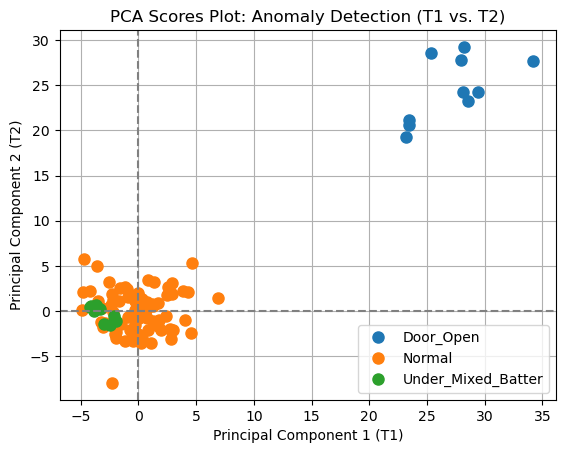

In [19]:



# Scatter plot
groups = plot_data.groupby('Fault_Type')
for name, group in groups:
    plt.plot(group[0], group[1], marker='o', linestyle='', ms=8, label=name)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.title('PCA Scores Plot: Anomaly Detection (T1 vs. T2)')
plt.xlabel('Principal Component 1 (T1)')
plt.ylabel('Principal Component 2 (T2)')
plt.legend()
plt.grid(True)
plt.show()

# You should see the 'Normal' group clustered near the center (0,0) and the 
# 'Door_Open' and 'Under_Mixed_Batter' groups separated from the main cluster.

Modeling Step 3: Quality Prediction ($\text{PLS}$)$\text{PLS}$ links the process data (CPPs) to the final quality (CQAs).

In [22]:
# --- 1. Prepare Target Variable (Final_Height) ---
Y_target = cqa_df.set_index('Batch_ID')['Final_Height']


In [24]:
# Ensure X data aligns with Y data (only use batches that finished)
X_pls = X_test.loc[Y_target.index]
X_pls_scaled = scaler.transform(X_pls) # Use the same scaler object

In [26]:
# --- 2. Build the PLS Regression Model ---
# PLS is a supervised technique, using both X and Y data.
pls = PLSRegression(n_components=3) # Use 3 components for PLS
pls.fit(X_pls_scaled, Y_target)

# --- 3. Predict Quality for All Batches ---
Y_pred = pls.predict(X_pls_scaled)


In [28]:
# Store results for visualization
results_df = pd.DataFrame({
    'Actual_Height': Y_target,
    'Predicted_Height': Y_pred.flatten()
}, index=Y_target.index)
results_df = results_df.merge(fault_types, left_index=True, right_index=True)


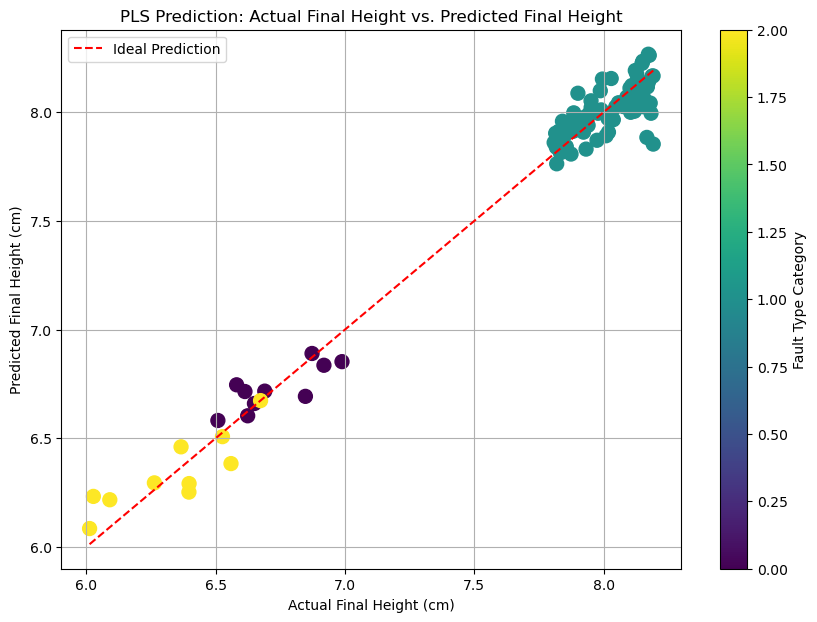

In [39]:
# --- 4. Visualize Prediction Accuracy ---
plt.figure(figsize=(10, 7))

# Scatter plot of Actual vs Predicted
plt.scatter(results_df['Actual_Height'], results_df['Predicted_Height'], 
            c=results_df['Fault_Type'].astype('category').cat.codes, 
            cmap='viridis', s=100)
# Add the perfect 45-degree line (Actual == Predicted)
plt.plot([min(results_df['Actual_Height']), max(results_df['Actual_Height'])], 
         [min(results_df['Actual_Height']), max(results_df['Actual_Height'])], 
         'r--', label='Ideal Prediction')

plt.title('PLS Prediction: Actual Final Height vs. Predicted Final Height')
plt.xlabel('Actual Final Height (cm)')
plt.ylabel('Predicted Final Height (cm)')
plt.colorbar(label='Fault Type Category')
plt.legend()
plt.grid(True)
plt.show()

# Narrative: Show that the PLS model successfully predicts low quality (low height)
# for the 'Door_Open' and 'Under_Mixed_Batter' batches.

# Save and Export the Trained Models

use the $\text{Python}$ library joblib to serialize and save the trained $\text{PCA}$ and $\text{PLS}$ objects, along with the StandardScaler object, to files in your trained_models/ direct

In [67]:
import joblib

# Assuming 'pca', 'pls', and 'scaler' are your trained objects
joblib.dump(pca, 'trained_models/pca_model.pkl')



['trained_models/pca_model.pkl']

In [69]:
joblib.dump(pls, 'trained_models/pls_model.pkl')

['trained_models/pls_model.pkl']

In [71]:
joblib.dump(scaler, 'trained_models/scaler_model.pkl')

['trained_models/scaler_model.pkl']